In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import History
from keras import callbacks
from keras import metrics
from keras import backend as K

from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import os, time
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from tqdm import tqdm

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from io import StringIO


In [68]:
DATA_PATH = "../../Data/"

IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated/"

#IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated_half_nv/"
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

IMG_SIZE = (224, 224) # original image size

In [3]:
SAVING_ON = True

## Activation Function Choise

https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c

For CNN developed, 3 major activation functions were taken into consideration: swish, relu and softmax.

Relu function does not have the vanishing gradient problem, computationaly inexpensive, faster convergence. 

## Functions

#### Mish Activation

In [4]:
## Mish Activation Function
def mish(x):
    return keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)

#### Compile

In [69]:
learning_rate = 0.00025
decay_rate = 0.2 # 10%

def compile_model(num_classes: int=7) -> Sequential:
    
    global IMG_SIZE
    
    dropout_rate = 0.2
    regularization = 0.01 # L1
    
    epsilon = 1e-06
    
    activation = activations.relu
    
    padding = "valid"
    # Rescaling is Standartization of the data, this layer will be used with colors 
    # to convert values from 0-255 into 0-1 range. This step is done to normalize data 
    # for Neural Network, key is to have mean value as close to 0 as possible, 
    # this will speed up learning and will provide faster convergence.
    
    #regularization = 0.005 # L2
    
    model = Sequential([
        layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),
         
        layers.Conv2D(16, (3,3), padding=padding, activation=activation,
                      kernel_regularizer=keras.regularizers.l1(regularization)),
        layers.MaxPooling2D(),
        
        layers.Dropout(dropout_rate),
        
        layers.Conv2D(32, (3,3), padding=padding, activation=activation,
                     kernel_regularizer=keras.regularizers.l1(regularization)),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3,3), padding=padding, activation=activation,
                     kernel_regularizer=keras.regularizers.l1(regularization)),
        layers.MaxPooling2D(),
        #layers.Dropout(dropout_rate),
        #layers.BatchNormalization(), # momentum=0.8 
        
        layers.Flatten(),
        layers.Dense(512, activation=activation),
        layers.Dense(num_classes, activation="softmax") # default linear activation
    ])
    
    # Try focal loss for uneven class distribution
    # Adagrad - Adaptive Gradient
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)     
    
    # CategoricalCrossentropy is used because labels are OneHotEncoder format
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model
    
    
    
    '''
    # ACC 81 VAL 77  # not so good with 224x224
    
    dropout_rate = 0.4
    regularization = 0.005
    
    model = Sequential([
        layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),
         
        layers.Conv2D(16, (3,3), padding="same", activation=mish, 
                      kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.MaxPooling2D(),
        
        layers.Conv2D(32, (3,3), padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.MaxPooling2D(),
         
        layers.Conv2D(64, (3,3), padding="same", activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.BatchNormalization(momentum=0.8),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),
                
        layers.Flatten(),
        layers.Dense(128, activation=mish,
                     kernel_regularizer=keras.regularizers.l2(regularization)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes) # default linear activation
    ])
    
    # Adagrad - Adaptive Gradient
    optimizer = keras.optimizers.Adagrad() # Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"]) #, run_eagerly=True)
    return model

    ''';

## TESTING

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 16)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None,

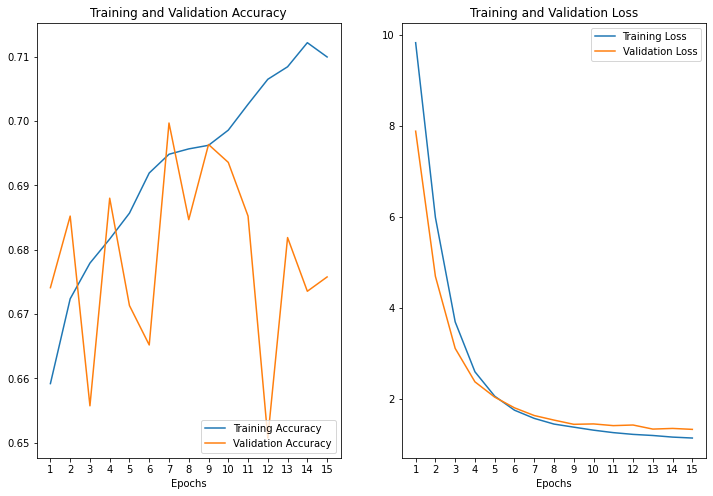

Time Elapsed :  0:25:35.032796


In [70]:
# COPY
epochs = 15

batch_size = 64
validation_split = 0.2

generator = ImageDataGenerator(validation_split=validation_split)
train_data = generator.flow_from_directory( 
        subset="training",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)
test_data = generator.flow_from_directory( 
        subset="validation",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)
start_time = time.time()


'''
print("Training Data Distribution")
print_data_distribution(train_data)
print("Testing Data Distribution")
print_data_distribution(train_data)


''';
model = compile_model()
model.summary()
fit_model(model, train_data, test_data, epochs, verbose=True, 
          augment="TEST_{0}".format(epochs))

print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

# regularization L2 0.01 15 epoch 512 Dense CMD CM CM HALF NEVI

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None,

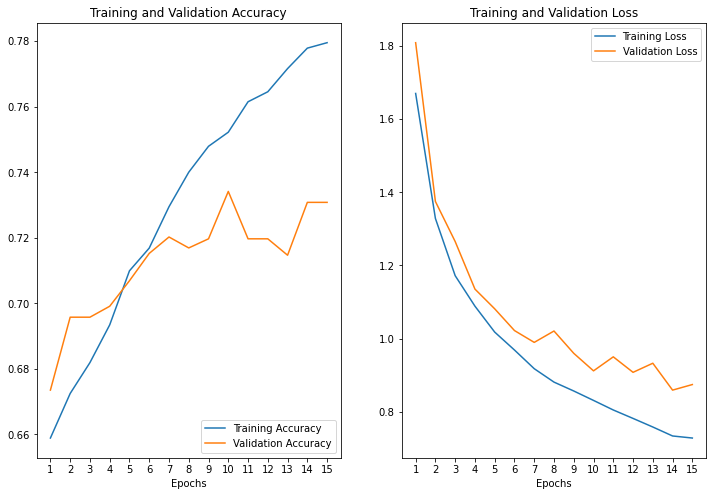

Time Elapsed :  0:25:30.369148


In [63]:
# regularization L2 0.01 15 epoch 512 Dense CMD CM CM

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                    

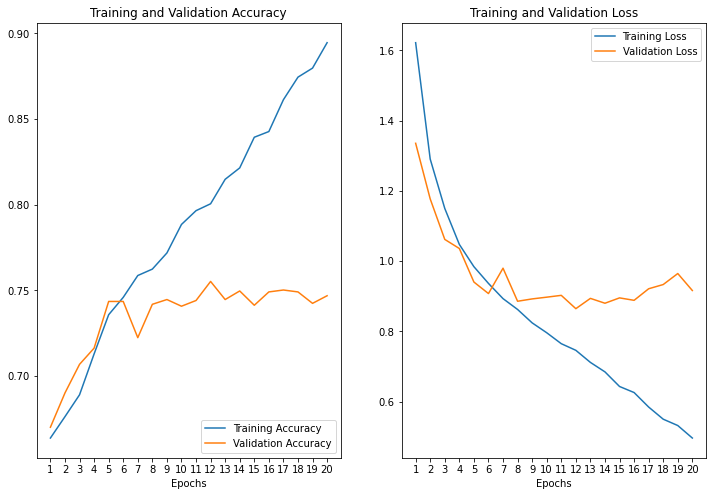

Time Elapsed :  0:31:14.738893


In [19]:
# regularization L2 0.01 20 epoch 512 Dense

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/20
113/113 [==============================] - 94s 826ms/step - loss: 9.5940 - accuracy: 0.6646 - val_loss: 7.3783 - val_accuracy: 0.6752
Epoch 2/20
113/113 [==============================] - 94s 835ms/step - loss: 5.8814 - accuracy: 0.6760 - val_loss: 4.5648 - val_accuracy: 0.6891
Epoch 3/20
113/113 [==============================] - 93s 823ms/step - loss: 3.7305 - accuracy: 0.6839 - val_loss: 3.0958 - val_accuracy: 0.6724
Epoch 4/20
113/113 [==============================] - 93s 820ms/step - loss: 2.7544 - accuracy: 0.6902 - val_loss: 2.4574 - val_accuracy: 0.6991
Epoch 5/20
113/113 [==============================] - 93s 824ms/step - loss: 2.3121 - accuracy: 0.6879 - val_loss: 2.1550 - val_accuracy: 0.7030
Epoch 6/20
113/113 [==============================] - 92s 819ms/step - loss: 2.0437 - accuracy: 0.6965 - val_loss: 1.9188 - val_accuracy: 0.7097
Epoch 7/20
113/113 [==========================

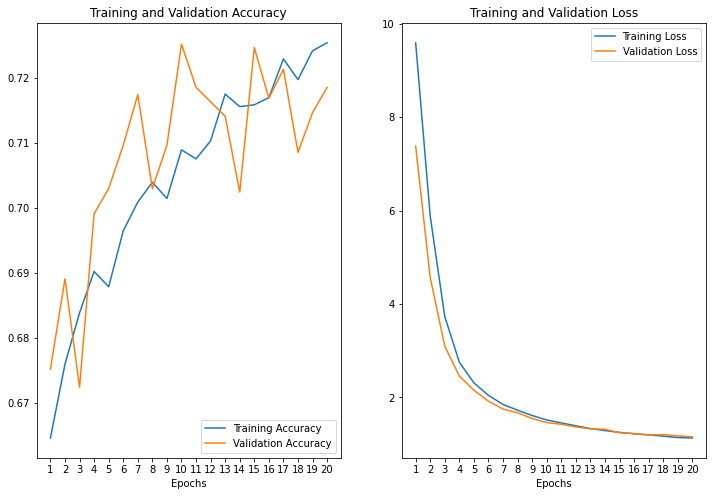

Time Elapsed :  0:31:27.476216


In [80]:
# regularization L1 0.01 20 epoch

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/15
113/113 [==============================] - 103s 889ms/step - loss: 9.4690 - accuracy: 0.6669 - val_loss: 7.2130 - val_accuracy: 0.6730
Epoch 2/15
113/113 [==============================] - 98s 867ms/step - loss: 5.7033 - accuracy: 0.6768 - val_loss: 4.3632 - val_accuracy: 0.6846
Epoch 3/15
113/113 [==============================] - 96s 853ms/step - loss: 3.5691 - accuracy: 0.6958 - val_loss: 2.9602 - val_accuracy: 0.7019
Epoch 4/15
113/113 [==============================] - 96s 852ms/step - loss: 2.6954 - accuracy: 0.7029 - val_loss: 2.4160 - val_accuracy: 0.7258
Epoch 5/15
113/113 [==============================] - 98s 864ms/step - loss: 2.3178 - accuracy: 0.7134 - val_loss: 2.1788 - val_accuracy: 0.7102
Epoch 6/15
113/113 [==============================] - 96s 846ms/step - loss: 2.0977 - accuracy: 0.7163 - val_loss: 1.9818 - val_accuracy: 0.7236
Epoch 7/15
113/113 [=========================

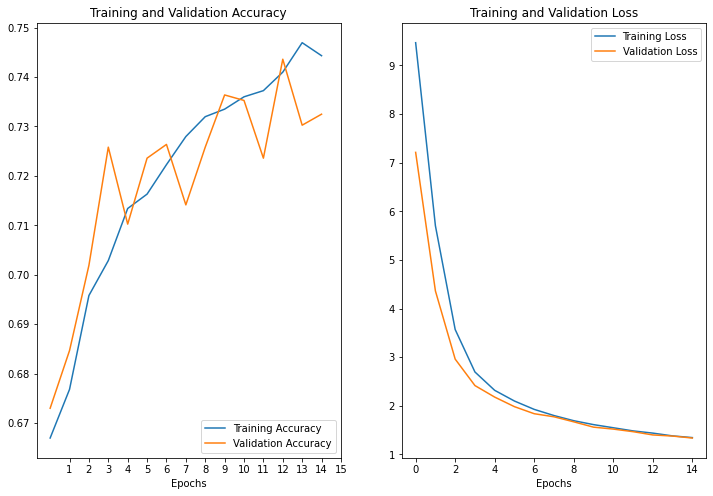

Time Elapsed :  0:24:26.996536


In [73]:
# regularization L1 0.01 15 epoch

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 92s 808ms/step - loss: 6.9224 - accuracy: 0.6693 - val_loss: 5.2022 - val_accuracy: 0.6730
Epoch 2/10
113/113 [==============================] - 91s 809ms/step - loss: 4.0630 - accuracy: 0.6742 - val_loss: 3.0145 - val_accuracy: 0.6997
Epoch 3/10
113/113 [==============================] - 92s 814ms/step - loss: 2.4574 - accuracy: 0.6840 - val_loss: 1.9973 - val_accuracy: 0.6874
Epoch 4/10
113/113 [==============================] - 91s 808ms/step - loss: 1.8151 - accuracy: 0.6904 - val_loss: 1.6390 - val_accuracy: 0.6919
Epoch 5/10
113/113 [==============================] - 92s 810ms/step - loss: 1.5700 - accuracy: 0.6977 - val_loss: 1.4563 - val_accuracy: 0.7030
Epoch 6/10
113/113 [==============================] - 93s 822ms/step - loss: 1.4420 - accuracy: 0.6995 - val_loss: 1.3696 - val_accuracy: 0.7058
Epoch 7/10
113/113 [==========================

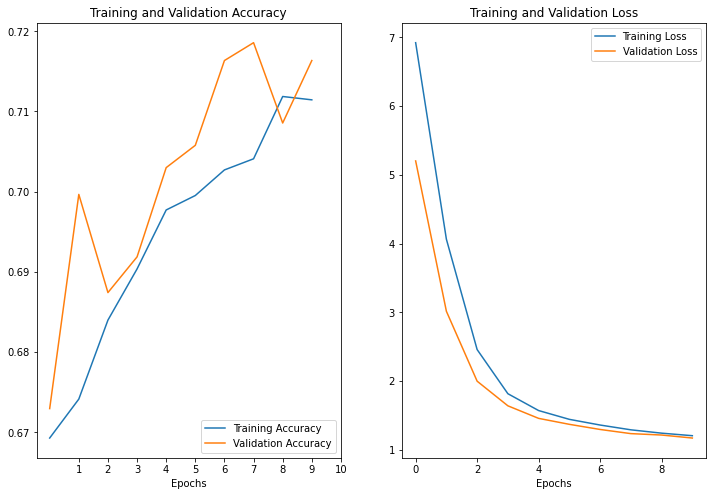

Time Elapsed :  0:15:50.450113


In [69]:
# regularization L1 0.007

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 90s 791ms/step - loss: 9.4037 - accuracy: 0.6626 - val_loss: 7.0533 - val_accuracy: 0.6719
Epoch 2/10
113/113 [==============================] - 90s 792ms/step - loss: 5.4347 - accuracy: 0.6725 - val_loss: 4.0199 - val_accuracy: 0.6741
Epoch 3/10
113/113 [==============================] - 90s 794ms/step - loss: 3.2196 - accuracy: 0.6773 - val_loss: 2.5821 - val_accuracy: 0.6908
Epoch 4/10
113/113 [==============================] - 90s 800ms/step - loss: 2.3348 - accuracy: 0.6884 - val_loss: 2.0817 - val_accuracy: 0.7063
Epoch 5/10
113/113 [==============================] - 93s 823ms/step - loss: 1.9753 - accuracy: 0.6923 - val_loss: 1.8376 - val_accuracy: 0.7108
Epoch 6/10
113/113 [==============================] - 94s 829ms/step - loss: 1.7872 - accuracy: 0.6952 - val_loss: 1.6723 - val_accuracy: 0.7113
Epoch 7/10
113/113 [==========================

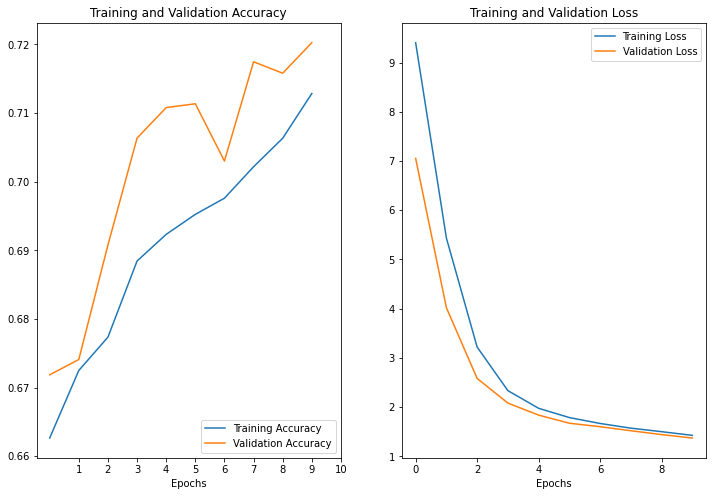

Time Elapsed :  0:15:33.667653


In [62]:
# regularization L1 0.005

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 91s 793ms/step - loss: 9.3778 - accuracy: 0.6633 - val_loss: 7.1067 - val_accuracy: 0.6696
Epoch 2/10
113/113 [==============================] - 90s 793ms/step - loss: 5.5030 - accuracy: 0.6783 - val_loss: 4.1385 - val_accuracy: 0.6846
Epoch 3/10
113/113 [==============================] - 89s 791ms/step - loss: 3.2824 - accuracy: 0.6891 - val_loss: 2.6329 - val_accuracy: 0.6858
Epoch 4/10
113/113 [==============================] - 90s 793ms/step - loss: 2.3268 - accuracy: 0.6930 - val_loss: 2.0705 - val_accuracy: 0.7036
Epoch 5/10
113/113 [==============================] - 92s 819ms/step - loss: 1.9357 - accuracy: 0.6958 - val_loss: 1.8273 - val_accuracy: 0.7002
Epoch 6/10
113/113 [==============================] - 90s 796ms/step - loss: 1.7470 - accuracy: 0.6972 - val_loss: 1.6343 - val_accuracy: 0.7214
Epoch 7/10
113/113 [==========================

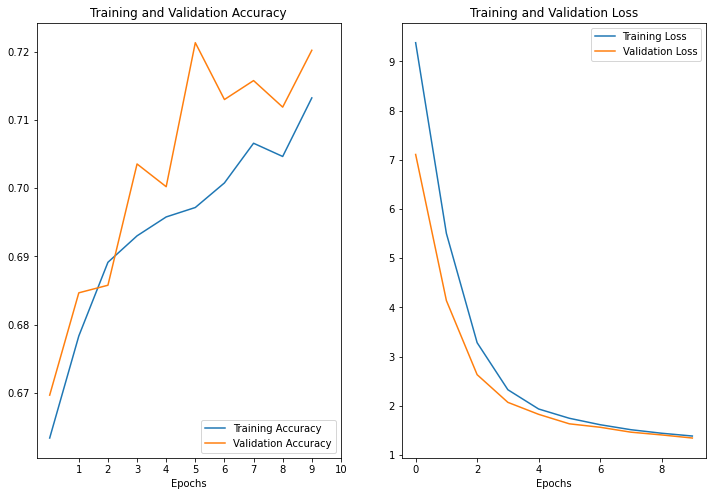

Time Elapsed :  0:15:24.391693


In [61]:
# regularization L1 0.01

In [ ]:
# keras.callbacks.LearningRateScheduler
# kernel initializer as param

#### Check Testing and Training Data Distribution

In [53]:
def print_data_distribution(iter_data: keras.preprocessing.image.DirectoryIterator):
    
    # combine data from iterator
    labels_all = iter_data.labels
    n_samples = len(labels_all)   # sum(1 for _ in iter)
    
    class_index = iter_data.class_indices
    
    # count occurences of each class label
    for index, value in class_index.items():
        count = np.count_nonzero(labels_all==value)
        perc = round(count/n_samples*100,2)
        print("{:6}{:8}{:8}%".format(index, count, perc))
        
print("Training Data Distribution")
print_data_distribution(train_data)
print("\nTestining Data Distribution")
print_data_distribution(test_data)

Training Data Distribution
akiec      236    3.27%
bcc        370    5.13%
bkl        792   10.98%
df          83    1.15%
mel        801   11.11%
nv        4828   66.94%
vasc       102    1.41%

Testining Data Distribution
akiec       58    3.23%
bcc         92    5.12%
bkl        197   10.96%
df          20    1.11%
mel        200   11.12%
nv        1206   67.07%
vasc        25    1.39%


#### Fit Model

In [6]:
# Logarithmic decay function for learning rate
def exp_decay(epoch: int) -> float:
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [7]:
def fit_model(model: Sequential, train_ds: Dataset, test_ds: Dataset, 
              epochs: int=10, augment: str="no_augment", verbose: bool=True) -> None:
    global SAVING_ON
    
    #trigger = callbacks.EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.001,
    #                                  patience=10, restore_best_weights=True)
    '''
    early_stop = callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.01,
                                      patience=5, restore_best_weights=True)
    save_weights = callbacks.ModelCheckpoint(
                "/output/checkpoints/chkp_EP_{epoch:02d}_VL_{val_loss:.2f}.hdf5", 
                save_best_only=True, monitor="val_loss", mode="min", min_delta=0.01)
    ''';
    lr_sheduler = callbacks.LearningRateScheduler(exp_decay)
    
    history = model.fit(train_ds, validation_data=test_ds, epochs=epochs)
                       #callbacks=[lr_sheduler]) 
                        #callbacks=[early_stop, save_weights])
    epochs = len(history.history['loss'])
    print("Epoch Length        : {0}".format(epochs))
    
    if verbose:
        evaluate_model(model, train_ds, test_ds)
        print_training_history(history)
    
    if SAVING_ON:
        model.save("output\keras_models\skin_classifier_{0}_{1}.keras".format(epochs, augment))

#### Evaluate

In [8]:
def evaluate_model(model: Sequential, train_ds: Dataset, test_ds: Dataset) -> None:
    acc_value = model.evaluate(train_ds, verbose=0)[1]
    val_acc_value = model.evaluate(test_ds, verbose=0)[1]
    print("Model Accuracy      : {0:.4f}".format(acc_value))
    print("Validation Accuracy : {0:.4f}".format(val_acc_value))

#### Training History

In [9]:
def print_training_history(history: History) -> None:
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = len(history.history['loss'])
    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
    plt.xlabel("Epochs")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
    plt.xlabel("Epochs")
    plt.title("Training and Validation Loss")
    plt.show()

#### Filters and Weights

In [10]:
def print_filters(model: Sequential, plot_weights: bool=False, 
                  test_img_path: str="input/ISIC_0024891.jpg") -> None:
    global IMG_SIZE
    # Dynamically get convolution layer indexes from model
    layer_indx = [i for i,layer in enumerate(model.layers) if "Conv" in str(layer)]

    for layer_i in layer_indx:
        conv_layer = model.layers[layer_i]
        print("Filters     : {0}".format(conv_layer.filters))
        print("Kernel Size : {0}".format(conv_layer.kernel_size))
        
        # Recreate model with a single layer        
        model_t = keras.Model(inputs=model.inputs, outputs=conv_layer.output)

        # Convert image to array
        img = load_img(test_img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)

        # plot all maps (filters)
        feature_maps = model_t.predict(img)

        cols = 8
        rows = int(conv_layer.filters/cols)

        for i in range(rows*cols):
            ax = pyplot.subplot(cols, cols, i+1)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, i], cmap='gray')

        # show the figure
        plt.show();

        # Plot Filter Weights
        if plot_weights:
            x1w = conv_layer.get_weights()[0][:,:,0,:]
            for i in range(0,conv_layer.filters):
                ax = plt.subplot(cols, cols, i+1)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(x1w[:,:,i], interpolation="nearest", cmap="gray")
            plt.show();

#### Confusion Matrix

In [11]:
def print_confusion_matrix(model: Sequential, val_image_path: str, 
                           normalize: bool=False) -> pd.DataFrame:
    global IMG_SIZE

    # Get validation images
    batch_size = 64

    generator = ImageDataGenerator()
    image_ds_validation = generator.flow_from_directory(
            directory=val_image_path,
            target_size=IMG_SIZE,
            batch_size=batch_size,
            shuffle=False # maintains the order to match labels with predictions
    )

    class_names = image_ds_validation.class_indices

    # Get actual y (Truth)
    y = image_ds_validation.labels

    # Make predictions using existing model
    y_pred = model.predict(image_ds_validation)
    # Convert arrays of predictions into integers
    y_pred_int = np.argmax(y_pred, axis=1)

    # Display Confusion Matrix (normalized and not)
    cm = confusion_matrix(y, y_pred_int, normalize=("true" if normalize else None) )
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();

    # Here Recall is Sensitivity
    print("Accuracy Score : ", round(accuracy_score(y, y_pred_int),4))
    # Replaced by DataFrame with added Specificity
    #print("Classification Report :\n", classification_report(y, y_pred_int))

    # Get data from classification report and parse it
    cr = classification_report(y, y_pred_int, digits=4, zero_division=0)
    cr = cr[:cr.index("accuracy")]

    # Remove unwanted spaces 
    while cr.find("  ") > -1:
        cr = cr.replace("  "," ")
    cr = "\n".join([row.strip() for row in cr.split("\n") if row.strip()])

    # Create Pandas DataFrame from String
    c_report = StringIO(cr)
    df = pd.read_csv(c_report, sep=" ")

    # Calculate Specificity
    specificity = []
    tn_total = 0 # Total Negatives
    for i in range(len(class_names)):
        tn_total += cm[i,i]

    for i in range(len(class_names)):
        tn = tn_total - cm[i,i] # total True Negatives minus current cell
        fp = sum(cm[:,i]) - cm[i,i] # current column minus current cell
        specificity.append( round(tn/(tn+fp), 4))
    df["specificity"] = specificity

    # Change columns name and order
    # df.rename(columns={"recall":"sensitivity","support":"total"}, inplace=True)
    columns = df.columns.tolist()
    columns = columns[0:2] + columns[4:] + columns[2:4]
    df = df[columns]

    df["label"] = class_names
    df.set_index("label", drop=True, inplace=True)

    return df

#print_confusion_matrix(model, IMAGES_PATH_VALIDATION)

## KFold
 Deprecated, better approach used:
 - flow_from_dataframe and flow_from_directory instead of image_dataset_from_directory allows to use way less RAM and allows bigger batch size without stalling the whole system
 - it was decided to leave this code here as it has produced models and statistics used in research

Found 9013 files belonging to 7 classes.


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 --- KFold Iteration 1 --- 
Epoch 1/150
226/226 [==============================] - 81s 339ms/step - loss: 2.6297 - accuracy: 0.6548 - val_loss: 2.4236 - val_accuracy: 0.7031
Epoch 2/150
226/226 [==============================] - 77s 325ms/step - loss: 2.5051 - accuracy: 0.6816 - val_loss: 2.3729 - val_accuracy: 0.7115
Epoch 3/150
226/226 [==============================] - 77s 326ms/step - loss: 2.4455 - accuracy: 0.6845 - val_loss: 2.3412 - val_accuracy: 0.7076
Epoch 4/150
226/226 [==============================] - 77s 326ms/step - loss: 2.3995 - accuracy: 0.6909 - val_loss: 2.2894 - val_accuracy: 0.7249
Epoch 5/150
226/226 [==============================] - 77s 325ms/step - loss: 2.3633 - accuracy: 0.7035 - val_loss: 2.2594 - val_accuracy: 0.7260
Epoch 6/150
226/226 [==============================] - 77s 326ms/step - loss: 2.3280 - accuracy: 0.7045 - val_loss: 2.2419 - val_accuracy: 0.7238
Epoch 7/150
226/226 [==============================] - 77s 324ms/step - loss: 2.2952 - accuracy:

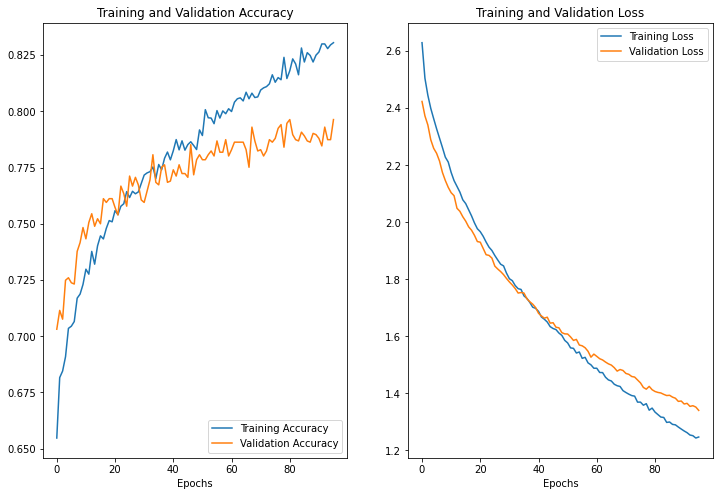

 20%|███████████████▌                                                              | 1/5 [2:05:29<8:21:58, 7529.56s/it]

 --- KFold Iteration 2 --- 
Epoch 1/150
226/226 [==============================] - 83s 363ms/step - loss: 2.6337 - accuracy: 0.6541 - val_loss: 2.4492 - val_accuracy: 0.7009
Epoch 2/150
226/226 [==============================] - 82s 361ms/step - loss: 2.4966 - accuracy: 0.6816 - val_loss: 2.3824 - val_accuracy: 0.7093
Epoch 3/150
226/226 [==============================] - 82s 361ms/step - loss: 2.4384 - accuracy: 0.6872 - val_loss: 2.3268 - val_accuracy: 0.7182
Epoch 4/150
226/226 [==============================] - 82s 361ms/step - loss: 2.3821 - accuracy: 0.7010 - val_loss: 2.2915 - val_accuracy: 0.7282
Epoch 5/150
226/226 [==============================] - 82s 362ms/step - loss: 2.3466 - accuracy: 0.7068 - val_loss: 2.2561 - val_accuracy: 0.7333
Epoch 6/150
226/226 [==============================] - 82s 361ms/step - loss: 2.3139 - accuracy: 0.7160 - val_loss: 2.2251 - val_accuracy: 0.7539
Epoch 7/150
226/226 [==============================] - 82s 361ms/step - loss: 2.2676 - accuracy:

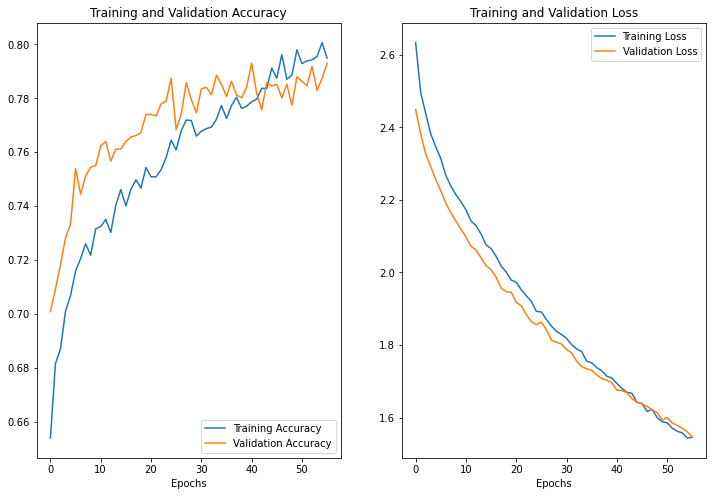

 40%|███████████████████████████████▏                                              | 2/5 [3:23:19<4:52:23, 5847.72s/it]

 --- KFold Iteration 3 --- 
Epoch 1/150
226/226 [==============================] - 89s 390ms/step - loss: 2.6440 - accuracy: 0.6606 - val_loss: 2.4947 - val_accuracy: 0.6802
Epoch 2/150
226/226 [==============================] - 88s 389ms/step - loss: 2.5289 - accuracy: 0.6753 - val_loss: 2.4263 - val_accuracy: 0.6914
Epoch 3/150
226/226 [==============================] - 88s 390ms/step - loss: 2.4720 - accuracy: 0.6863 - val_loss: 2.3992 - val_accuracy: 0.6897
Epoch 4/150
226/226 [==============================] - 88s 390ms/step - loss: 2.4250 - accuracy: 0.6901 - val_loss: 2.3361 - val_accuracy: 0.7031
Epoch 5/150
226/226 [==============================] - 88s 390ms/step - loss: 2.3977 - accuracy: 0.6927 - val_loss: 2.3359 - val_accuracy: 0.6925
Epoch 6/150
226/226 [==============================] - 88s 390ms/step - loss: 2.3544 - accuracy: 0.6960 - val_loss: 2.2952 - val_accuracy: 0.7026
Epoch 7/150
226/226 [==============================] - 89s 391ms/step - loss: 2.3249 - accuracy:

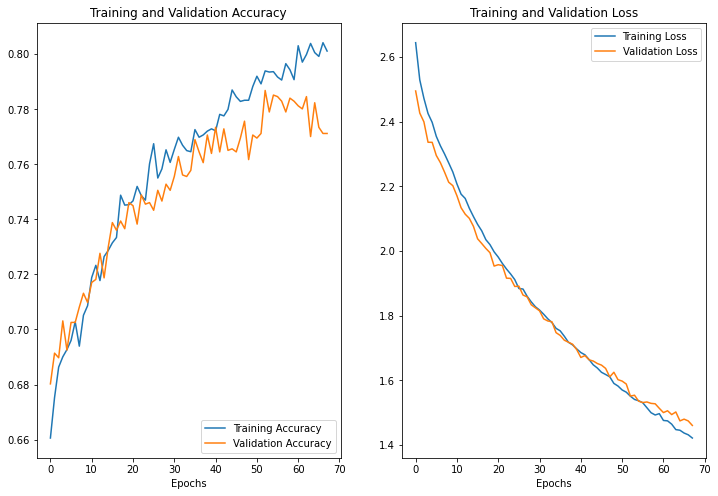

 60%|██████████████████████████████████████████████▊                               | 3/5 [5:05:04<3:18:49, 5964.97s/it]

 --- KFold Iteration 4 --- 
Epoch 1/150
226/226 [==============================] - 95s 417ms/step - loss: 2.6172 - accuracy: 0.6622 - val_loss: 2.4969 - val_accuracy: 0.6730
Epoch 2/150
226/226 [==============================] - 94s 416ms/step - loss: 2.4987 - accuracy: 0.6823 - val_loss: 2.4467 - val_accuracy: 0.6752
Epoch 3/150
226/226 [==============================] - 95s 418ms/step - loss: 2.4462 - accuracy: 0.6879 - val_loss: 2.4153 - val_accuracy: 0.6780
Epoch 4/150
226/226 [==============================] - 95s 418ms/step - loss: 2.4066 - accuracy: 0.6959 - val_loss: 2.3711 - val_accuracy: 0.6936
Epoch 5/150
226/226 [==============================] - 94s 416ms/step - loss: 2.3699 - accuracy: 0.7002 - val_loss: 2.3325 - val_accuracy: 0.6981
Epoch 6/150
226/226 [==============================] - 95s 418ms/step - loss: 2.3358 - accuracy: 0.7050 - val_loss: 2.2942 - val_accuracy: 0.6936
Epoch 7/150
226/226 [==============================] - 94s 417ms/step - loss: 2.2926 - accuracy:

Epoch Length        : 111
Model Accuracy      : 0.8673
Validation Accuracy : 0.7807


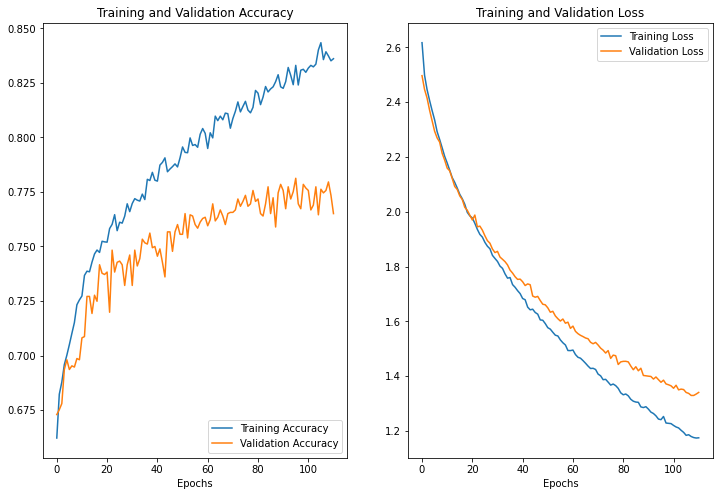

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [8:01:56<2:09:59, 7799.71s/it]

 --- KFold Iteration 5 --- 
Epoch 1/150
226/226 [==============================] - 103s 448ms/step - loss: 2.6067 - accuracy: 0.6582 - val_loss: 2.4898 - val_accuracy: 0.7070
Epoch 2/150
226/226 [==============================] - 101s 448ms/step - loss: 2.4897 - accuracy: 0.6855 - val_loss: 2.4372 - val_accuracy: 0.7070
Epoch 3/150
226/226 [==============================] - 101s 447ms/step - loss: 2.4406 - accuracy: 0.6836 - val_loss: 2.4042 - val_accuracy: 0.7121
Epoch 4/150
226/226 [==============================] - 101s 448ms/step - loss: 2.3866 - accuracy: 0.6963 - val_loss: 2.3914 - val_accuracy: 0.6987
Epoch 5/150
226/226 [==============================] - 101s 448ms/step - loss: 2.3594 - accuracy: 0.7020 - val_loss: 2.3485 - val_accuracy: 0.7165
Epoch 6/150
226/226 [==============================] - 101s 447ms/step - loss: 2.3331 - accuracy: 0.7017 - val_loss: 2.3152 - val_accuracy: 0.7188
Epoch 7/150
226/226 [==============================] - 101s 447ms/step - loss: 2.2946 - ac

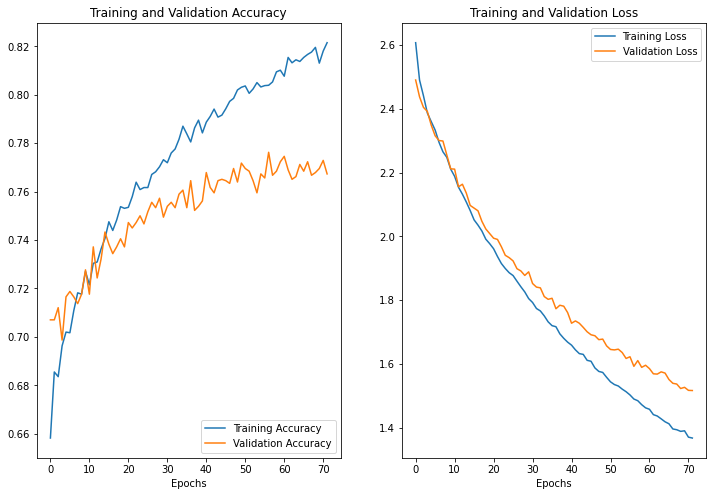

100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [10:05:27<00:00, 7265.58s/it]

 === KFOLD AVERAGE STATISTICS === 
loss: 1.385972762107849 - accuracy: 0.8366154313087464 - val_loss: 1.5333009958267212 - val_accuracy: 0.78125
Time Elapsed :  10:05:29.630406


In [32]:
'''
epochs = 150

start_time = time.time()

image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGES_PATH_SEPARATED,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True
)

for images, labels in image_ds:
    model_input_shape = images.shape
    break
    
class_names = image_ds.class_names
num_classes = len(class_names)

statistics_data = [[],[],[],[]]

total_folds = 5 # 5
total_size = len(image_ds) 
fold_size = int(total_size / total_folds) 

if True:
    for i in tqdm(range(0, total_folds)): 
        print(" --- KFold Iteration {0} --- ".format(i+1))
        # split data looks strange but all it does 
        # it splits and shifts every iteration of the loop
        train_d_head = image_ds.take(i*fold_size)  
        rest_d = image_ds.skip(i*fold_size)
        test_d = rest_d.take(fold_size)
        train_d_tail = rest_d.skip(fold_size)
        train_d = train_d_head.concatenate(train_d_tail)
    
        # Prefetching overlaps data preprocessing and model execution while training. 
        # When model is performing training step, input pipeline is reading data for next step. 
        # This reduces each step time it takes for training and for reading.
        test_d = test_d.prefetch(buffer_size=32)
        train_d = train_d.prefetch(buffer_size=32)

        model = compile_model()
        fit_model(model, train_d, test_d, epochs, verbose=True, 
                  augment="kfold_{0}".format(i+1))

        # gather statistics
        train_evaluation = model.evaluate(train_d, verbose=0)
        validation_evaluation = model.evaluate(test_d, verbose=0)

        statistics_data[0].append(train_evaluation[0]) # loss
        statistics_data[1].append(train_evaluation[1]) # accuracy
        statistics_data[2].append(validation_evaluation[0]) # val_loss
        statistics_data[3].append(validation_evaluation[1]) # val_accuracy

    print(" === KFOLD AVERAGE STATISTICS === ")
    print("loss: {0} - accuracy: {1} - val_loss: {2} - val_accuracy: {3}".format(
        np.average(statistics_data[0]), np.average(statistics_data[1]),
        np.average(statistics_data[2]), np.average(statistics_data[3])
    ))
    print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

''';

## KFOLD (2)
Deprecated

Found 9013 files belonging to 7 classes.


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 --- KFold Iteration 1 --- 
Epoch 1/150
226/226 [==============================] - 80s 335ms/step - loss: 2.6171 - accuracy: 0.6523 - val_loss: 2.4816 - val_accuracy: 0.6791
Epoch 2/150
226/226 [==============================] - 79s 336ms/step - loss: 2.4853 - accuracy: 0.6768 - val_loss: 2.4112 - val_accuracy: 0.6964
Epoch 3/150
226/226 [==============================] - 79s 334ms/step - loss: 2.4209 - accuracy: 0.6941 - val_loss: 2.3764 - val_accuracy: 0.6981
Epoch 4/150
226/226 [==============================] - 80s 337ms/step - loss: 2.3854 - accuracy: 0.6975 - val_loss: 2.3360 - val_accuracy: 0.7121
Epoch 5/150
226/226 [==============================] - 77s 325ms/step - loss: 2.3440 - accuracy: 0.7013 - val_loss: 2.2898 - val_accuracy: 0.7266
Epoch 6/150
226/226 [==============================] - 76s 320ms/step - loss: 2.3110 - accuracy: 0.7057 - val_loss: 2.2713 - val_accuracy: 0.7193
Epoch 7/150
226/226 [==============================] - 76s 321ms/step - loss: 2.2721 - accuracy:

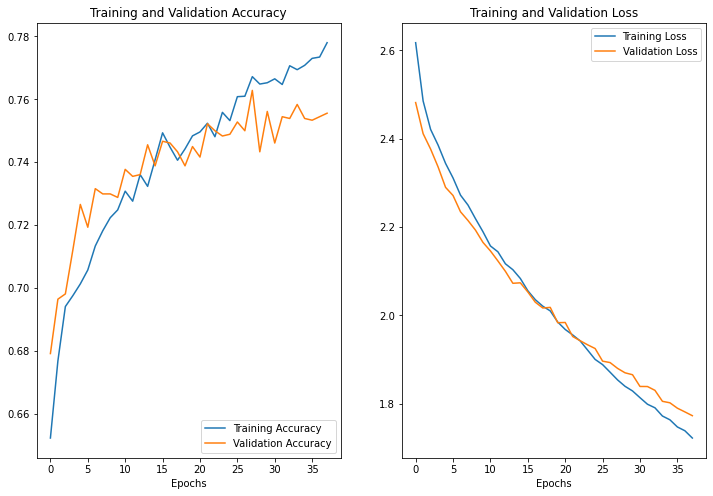

 20%|████████████████                                                                | 1/5 [49:38<3:18:33, 2978.40s/it]

 --- KFold Iteration 2 --- 
Epoch 1/150
226/226 [==============================] - 82s 359ms/step - loss: 2.6201 - accuracy: 0.6590 - val_loss: 2.4312 - val_accuracy: 0.6892
Epoch 2/150
226/226 [==============================] - 81s 358ms/step - loss: 2.4982 - accuracy: 0.6784 - val_loss: 2.3811 - val_accuracy: 0.7076
Epoch 3/150
226/226 [==============================] - 81s 358ms/step - loss: 2.4350 - accuracy: 0.6888 - val_loss: 2.3373 - val_accuracy: 0.7126
Epoch 4/150
226/226 [==============================] - 81s 358ms/step - loss: 2.3962 - accuracy: 0.6955 - val_loss: 2.3041 - val_accuracy: 0.7126
Epoch 5/150
226/226 [==============================] - 81s 357ms/step - loss: 2.3551 - accuracy: 0.6996 - val_loss: 2.2741 - val_accuracy: 0.7238
Epoch 6/150
226/226 [==============================] - 81s 358ms/step - loss: 2.3281 - accuracy: 0.7036 - val_loss: 2.2571 - val_accuracy: 0.7260
Epoch 7/150
226/226 [==============================] - 81s 357ms/step - loss: 2.2952 - accuracy:

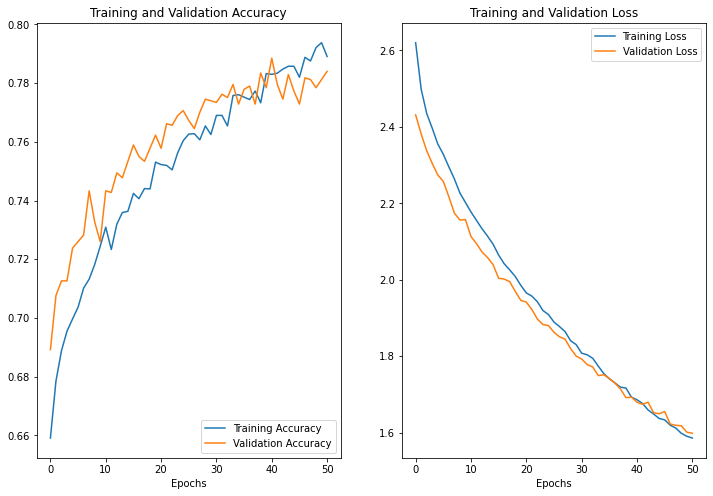

 40%|███████████████████████████████▏                                              | 2/5 [2:00:02<3:05:34, 3711.34s/it]

 --- KFold Iteration 3 --- 
Epoch 1/150
226/226 [==============================] - 91s 401ms/step - loss: 2.6260 - accuracy: 0.6592 - val_loss: 2.4913 - val_accuracy: 0.6975
Epoch 2/150
226/226 [==============================] - 89s 395ms/step - loss: 2.4974 - accuracy: 0.6769 - val_loss: 2.4204 - val_accuracy: 0.7015
Epoch 3/150
226/226 [==============================] - 89s 394ms/step - loss: 2.4364 - accuracy: 0.6898 - val_loss: 2.3602 - val_accuracy: 0.7098
Epoch 4/150
226/226 [==============================] - 89s 393ms/step - loss: 2.3869 - accuracy: 0.6945 - val_loss: 2.3235 - val_accuracy: 0.7121
Epoch 5/150
226/226 [==============================] - 90s 399ms/step - loss: 2.3348 - accuracy: 0.7056 - val_loss: 2.2880 - val_accuracy: 0.7182
Epoch 6/150
226/226 [==============================] - 90s 399ms/step - loss: 2.2997 - accuracy: 0.7113 - val_loss: 2.2489 - val_accuracy: 0.7182
Epoch 7/150
226/226 [==============================] - 90s 399ms/step - loss: 2.2589 - accuracy:

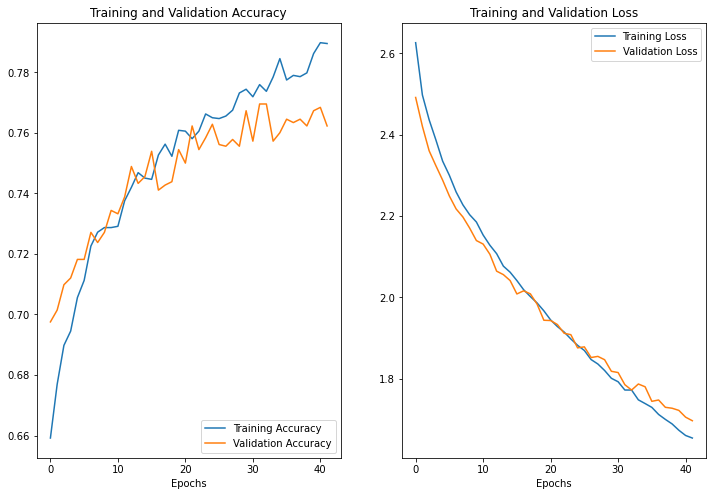

 60%|██████████████████████████████████████████████▊                               | 3/5 [3:05:02<2:06:35, 3797.55s/it]

 --- KFold Iteration 4 --- 
Epoch 1/150
226/226 [==============================] - 96s 422ms/step - loss: 2.6231 - accuracy: 0.6584 - val_loss: 2.4605 - val_accuracy: 0.6875
Epoch 2/150
226/226 [==============================] - 96s 424ms/step - loss: 2.4935 - accuracy: 0.6831 - val_loss: 2.4332 - val_accuracy: 0.6903
Epoch 3/150
226/226 [==============================] - 95s 422ms/step - loss: 2.4395 - accuracy: 0.6843 - val_loss: 2.3694 - val_accuracy: 0.6942
Epoch 4/150
226/226 [==============================] - 96s 422ms/step - loss: 2.3960 - accuracy: 0.6982 - val_loss: 2.3243 - val_accuracy: 0.7065
Epoch 5/150
226/226 [==============================] - 96s 425ms/step - loss: 2.3518 - accuracy: 0.7034 - val_loss: 2.3130 - val_accuracy: 0.7154
Epoch 6/150
226/226 [==============================] - 96s 424ms/step - loss: 2.3244 - accuracy: 0.7077 - val_loss: 2.2706 - val_accuracy: 0.7148
Epoch 7/150
226/226 [==============================] - 95s 421ms/step - loss: 2.2799 - accuracy:

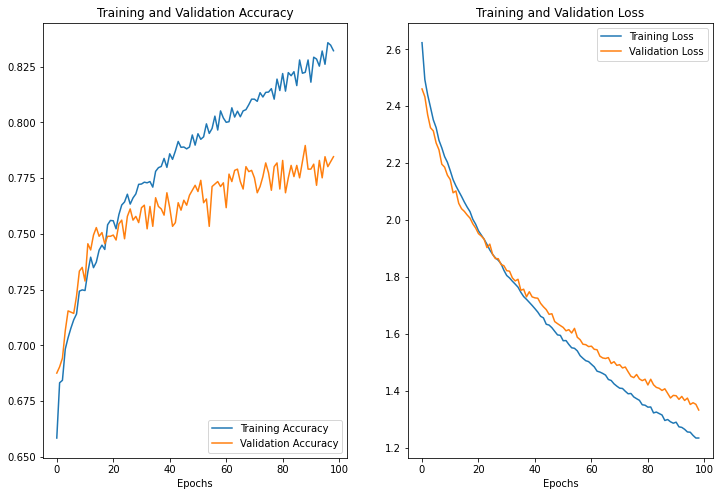

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [5:45:02<1:41:28, 6088.06s/it]

 --- KFold Iteration 5 --- 
Epoch 1/150
226/226 [==============================] - 102s 448ms/step - loss: 2.6092 - accuracy: 0.6597 - val_loss: 2.4600 - val_accuracy: 0.6964
Epoch 2/150
226/226 [==============================] - 101s 448ms/step - loss: 2.4844 - accuracy: 0.6836 - val_loss: 2.4016 - val_accuracy: 0.6998
Epoch 3/150
226/226 [==============================] - 101s 447ms/step - loss: 2.4319 - accuracy: 0.6949 - val_loss: 2.3687 - val_accuracy: 0.6998
Epoch 4/150
226/226 [==============================] - 102s 448ms/step - loss: 2.3943 - accuracy: 0.6984 - val_loss: 2.3452 - val_accuracy: 0.6992
Epoch 5/150
226/226 [==============================] - 101s 446ms/step - loss: 2.3574 - accuracy: 0.7060 - val_loss: 2.3094 - val_accuracy: 0.7081
Epoch 6/150
226/226 [==============================] - 101s 447ms/step - loss: 2.3255 - accuracy: 0.7063 - val_loss: 2.2872 - val_accuracy: 0.7048
Epoch 7/150
226/226 [==============================] - 102s 449ms/step - loss: 2.2942 - ac

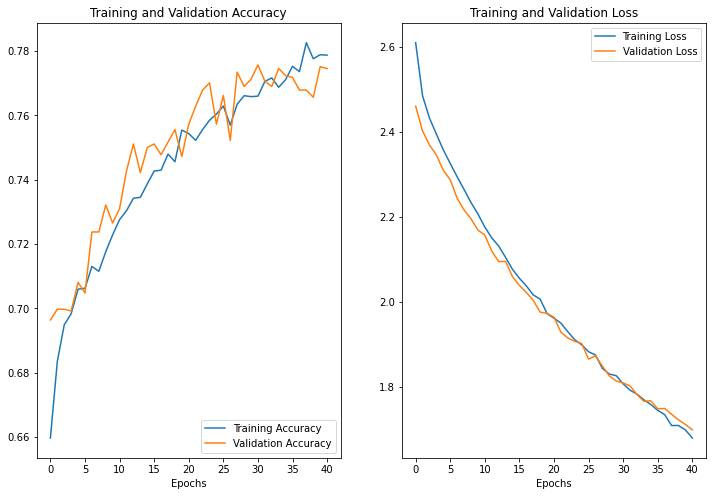

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [6:56:22<00:00, 4996.42s/it]

 === KFOLD AVERAGE STATISTICS === 
loss: 1.6093805313110352 - accuracy: 0.8127683281898499 - val_loss: 1.7153390645980835 - val_accuracy: 0.7723214268684387
Time Elapsed :  6:56:22.846047


In [410]:
'''
epochs = 150

start_time = time.time()

image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGES_PATH_SEPARATED,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True
)

for images, labels in image_ds:
    model_input_shape = images.shape
    break
    
class_names = image_ds.class_names
num_classes = len(class_names)

statistics_data = [[],[],[],[]]

total_folds = 5 # 5
total_size = len(image_ds) 
fold_size = int(total_size / total_folds) 

if True:
    for i in tqdm(range(0, total_folds)): 
        print(" --- KFold Iteration {0} --- ".format(i+1))
        # split data looks strange but all it does 
        # it splits and shifts every iteration of the loop
        train_d_head = image_ds.take(i*fold_size)  
        rest_d = image_ds.skip(i*fold_size)
        test_d = rest_d.take(fold_size)
        train_d_tail = rest_d.skip(fold_size)
        train_d = train_d_head.concatenate(train_d_tail)
    
        # Prefetching overlaps data preprocessing and model execution while training. 
        # When model is performing training step, input pipeline is reading data for next step. 
        # This reduces each step time it takes for training and for reading.
        test_d = test_d.prefetch(buffer_size=32)
        train_d = train_d.prefetch(buffer_size=32)

        model = compile_model()
        fit_model(model, train_d, test_d, epochs, verbose=True, 
                  augment="kfold_{0}".format(i+1))

        # gather statistics
        train_evaluation = model.evaluate(train_d, verbose=0)
        validation_evaluation = model.evaluate(test_d, verbose=0)

        statistics_data[0].append(train_evaluation[0]) # loss
        statistics_data[1].append(train_evaluation[1]) # accuracy
        statistics_data[2].append(validation_evaluation[0]) # val_loss
        statistics_data[3].append(validation_evaluation[1]) # val_accuracy

    print(" === KFOLD AVERAGE STATISTICS === ")
    print("loss: {0} - accuracy: {1} - val_loss: {2} - val_accuracy: {3}".format(
        np.average(statistics_data[0]), np.average(statistics_data[1]),
        np.average(statistics_data[2]), np.average(statistics_data[3])
    ))
    print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

''';

### === KFOLD AVERAGE STATISTICS === (TEST 1)
- loss: 1.385972762107849 
- accuracy: 0.8366154313087464 
- val_loss: 1.5333009958267212 
- val_accuracy: 0.78125
- Time Elapsed :  10:05:29.630406

### === KFOLD AVERAGE STATISTICS === (TEST 2)
- loss: 1.6093805313110352 
- accuracy: 0.8127683281898499 
- val_loss: 1.7153390645980835 
- val_accuracy: 0.7723214268684387
- Time Elapsed :  6:56:22.846047

## Confusion Matrix

Found 1002 files belonging to 7 classes.
Accuracy Score :  0.7645
Found 1002 files belonging to 7 classes.
Accuracy Score :  0.7784
Found 1002 files belonging to 7 classes.
Accuracy Score :  0.7695
Found 1002 files belonging to 7 classes.
Accuracy Score :  0.7705
Found 1002 files belonging to 7 classes.
Accuracy Score :  0.7605


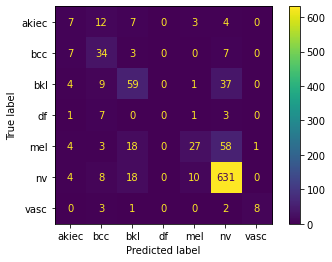

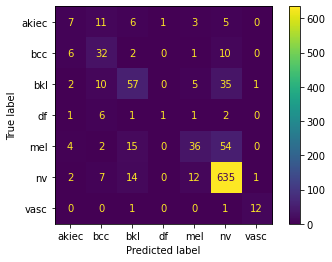

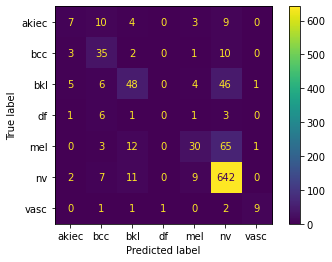

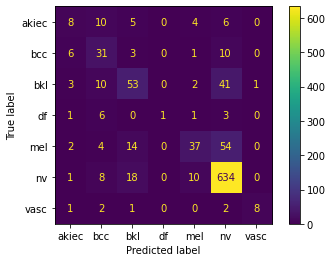

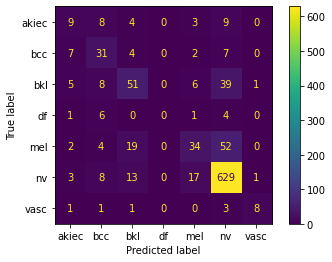

In [411]:
paths = [
    "skin_classifier_41_kfold_5.keras",
    "skin_classifier_99_kfold_4.keras",
    "skin_classifier_42_kfold_3.keras",
    "skin_classifier_51_kfold_2.keras",
    "skin_classifier_38_kfold_1.keras"
]
for p in paths:
    m = keras.models.load_model(
        "output/keras_models/"+p,
        custom_objects={"mish": mish}
    )
    print_confusion_matrix(m, IMAGES_PATH_VALIDATION)

## Test Data and Train Data Distribution Validation (for old KFold)
One of ways to increase model accuracy is to split test and train data in proportions similar to original dataset. Here is the proof that technique from deprecated KFold approach maintained proportions.

In [399]:
image_ds = tf.keras.preprocessing.image_dataset_from_directory(
        IMAGES_PATH_SEPARATED,
        image_size=IMG_SIZE,
        batch_size=32,
        shuffle=True
)
split = int(len(image_ds)*0.8)
train_d = image_ds.take(split)  
test_d = image_ds.skip(split)

Found 9013 files belonging to 7 classes.


In [20]:
def print_data_distribution(iter_data): # numpy iterator
    # combine data from iterator
    labels_all = [labels[i] for elements, labels in tqdm(iter_data) for i in range(len(labels))]
    labels_all = np.array(labels_all) 
    n_samples = len(labels_all)   # sum(1 for _ in iter)

    # count occurences of each class label
    for i, name in enumerate(class_names):
        count = np.count_nonzero(labels_all==i)
        perc = round(count/n_samples*100,2)
        print("{:6}{:8}{:8}%".format(name, count, perc))

In [395]:
print_data_distribution(image_ds.as_numpy_iterator())

282it [00:23, 12.00it/s]

akiec      294    3.26%
bcc        463    5.14%
bkl        989   10.97%
df         103    1.14%
mel       1002   11.12%
nv        6034   66.95%
vasc       128    1.42%


In [396]:
print_data_distribution(train_d.as_numpy_iterator())

225it [00:19, 11.84it/s]

akiec      238    3.31%
bcc        364    5.06%
bkl        787   10.93%
df          79     1.1%
mel        810   11.25%
nv        4823   66.99%
vasc        99    1.38%


In [397]:
print_data_distribution(test_d.as_numpy_iterator())

57it [00:22,  2.53it/s]

akiec       54    2.98%
bcc        102    5.63%
bkl        206   11.36%
df          22    1.21%
mel        196   10.81%
nv        1203   66.35%
vasc        30    1.65%


## Single Run (Testing)
Here different approach was tested. 
- using flow_from_dataframe and flow_from_directory instead of image_dataset_from_directory 

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 173s 2s/step - loss: 1.9878 - accuracy: 0.4768 - val_loss: 2.4715 - val_accuracy: 0.3065
Epoch 2/10
113/113 [==============================] - 173s 2s/step - loss: 1.2093 - accuracy: 0.6557 - val_loss: 1.3186 - val_accuracy: 0.6624
Epoch 3/10
113/113 [==============================] - 173s 2s/step - loss: 1.0175 - accuracy: 0.6938 - val_loss: 1.3057 - val_accuracy: 0.5562
Epoch 4/10
113/113 [==============================] - 173s 2s/step - loss: 0.9112 - accuracy: 0.7091 - val_loss: 3.8557 - val_accuracy: 0.6707
Epoch 5/10
113/113 [==============================] - 173s 2s/step - loss: 0.8394 - accuracy: 0.7341 - val_loss: 0.8269 - val_accuracy: 0.7286
Epoch 6/10
113/113 [==============================] - 173s 2s/step - loss: 0.7879 - accuracy: 0.7499 - val_loss: 1.6920 - val_accuracy: 0.3231
Epoch 7/10
113/113 [==============================] - 173s

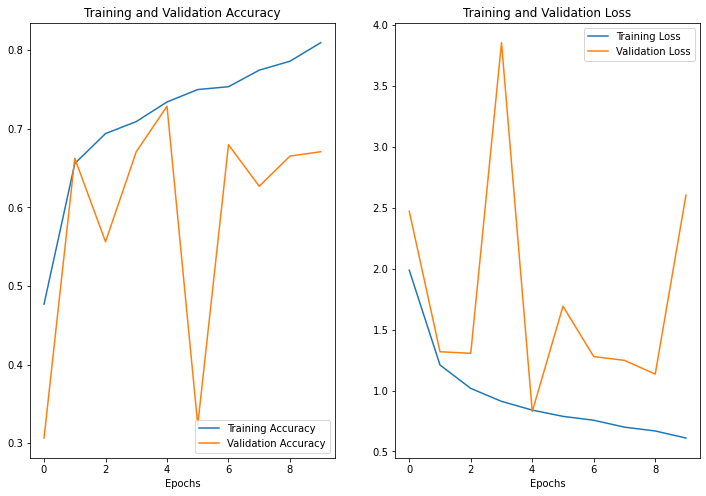

In [32]:

epochs = 10

if True:
    batch_size = 64
    generator = ImageDataGenerator(validation_split=0.2)
    train_data = generator.flow_from_directory( 
            subset="training",
            directory=IMAGES_PATH_SEPARATED,
            target_size=IMG_SIZE,
            batch_size=batch_size
    )
    test_data = generator.flow_from_directory( 
            subset="validation",
            directory=IMAGES_PATH_SEPARATED,
            target_size=IMG_SIZE,
            batch_size=batch_size
    )

    model = compile_model()  # todo remove input shape
    fit_model(model, train_data, test_data, epochs, verbose=True, 
              augment="testing_{0}".format(epochs))
    
    # More Layers _10 + RMSprop() 67/67

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 171s 2s/step - loss: 2.1551 - accuracy: 0.4677 - val_loss: 1.4452 - val_accuracy: 0.6924
Epoch 2/10
113/113 [==============================] - 171s 2s/step - loss: 1.4020 - accuracy: 0.6299 - val_loss: 2.5741 - val_accuracy: 0.6707
Epoch 3/10
113/113 [==============================] - 170s 2s/step - loss: 1.1362 - accuracy: 0.6804 - val_loss: 2.9073 - val_accuracy: 0.6707
Epoch 4/10
113/113 [==============================] - 171s 2s/step - loss: 1.0124 - accuracy: 0.6932 - val_loss: 1.2620 - val_accuracy: 0.6802
Epoch 5/10
113/113 [==============================] - 171s 2s/step - loss: 0.9750 - accuracy: 0.7080 - val_loss: 1.7716 - val_accuracy: 0.6780
Epoch 6/10
113/113 [==============================] - 171s 2s/step - loss: 0.9071 - accuracy: 0.7124 - val_loss: 1.1077 - val_accuracy: 0.6140
Epoch 7/10
113/113 [==============================] - 171s

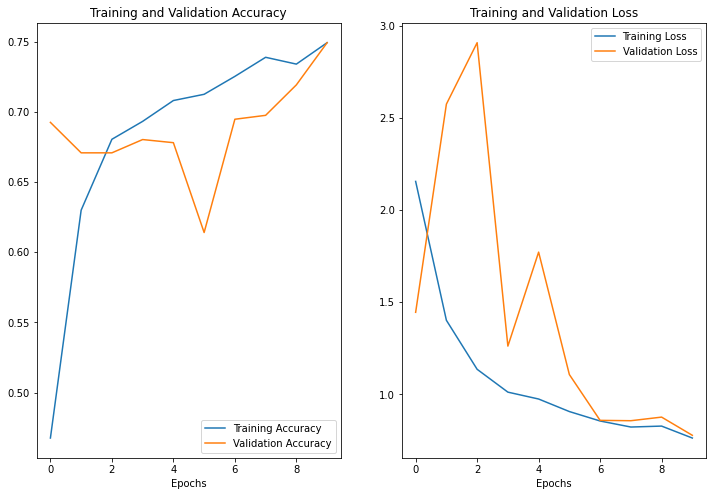

In [30]:
# More Layers _10 + Adam() 77/74  (Lower Validation Loss)

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.
Epoch 1/10
113/113 [==============================] - 171s 2s/step - loss: 2.4822 - accuracy: 0.3751 - val_loss: 1.5303 - val_accuracy: 0.6101
Epoch 2/10
113/113 [==============================] - 170s 2s/step - loss: 2.1283 - accuracy: 0.4734 - val_loss: 1.6017 - val_accuracy: 0.6140
Epoch 3/10
113/113 [==============================] - 170s 2s/step - loss: 1.9885 - accuracy: 0.5182 - val_loss: 1.5123 - val_accuracy: 0.6785
Epoch 4/10
113/113 [==============================] - 170s 2s/step - loss: 1.8576 - accuracy: 0.5556 - val_loss: 1.4332 - val_accuracy: 0.7008
Epoch 5/10
113/113 [==============================] - 170s 2s/step - loss: 1.8357 - accuracy: 0.5678 - val_loss: 1.4589 - val_accuracy: 0.6919
Epoch 6/10
113/113 [==============================] - 170s 2s/step - loss: 1.7488 - accuracy: 0.5965 - val_loss: 1.2794 - val_accuracy: 0.7347
Epoch 7/10
113/113 [==============================] - 170s

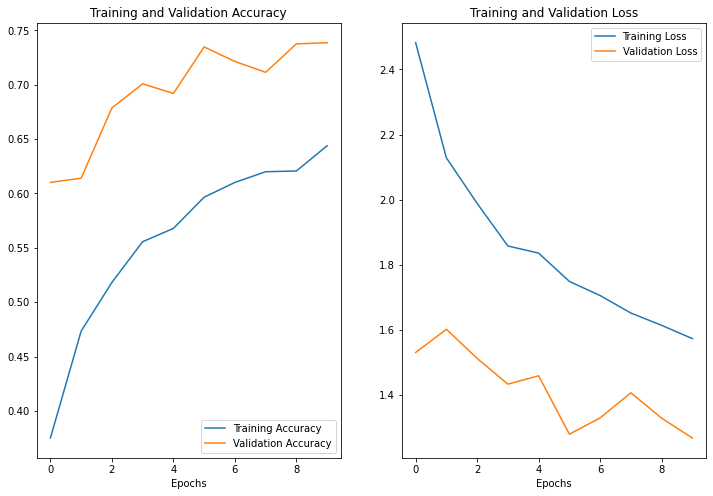

In [28]:
# More Layers _10 + Adagrad() 76/73

## KFold (New Approach, Testing)

In [42]:
from os import walk

# Get names (ids) of images saved for validation
validation_image_names = []
for (dirpath, dirnames, _) in walk(IMAGES_PATH_VALIDATION):
    for dirname in dirnames:
        for (_, _, filenames) in walk(dirpath+dirname):
            for filename in filenames:
                validation_image_names.append(filename[:-4])

0it [00:00, ?it/s]

Found 7208 non-validated image filenames belonging to 7 classes.
Found 1802 non-validated image filenames belonging to 7 classes.
Epoch 1/15
113/113 [==============================] - 173s 2s/step - loss: 2.4257 - accuracy: 0.3880 - val_loss: 1.7931 - val_accuracy: 0.5755
Epoch 2/15
113/113 [==============================] - 174s 2s/step - loss: 2.1192 - accuracy: 0.4727 - val_loss: 1.6518 - val_accuracy: 0.6398
Epoch 3/15
113/113 [==============================] - 172s 2s/step - loss: 2.0041 - accuracy: 0.5225 - val_loss: 1.5345 - val_accuracy: 0.6876
Epoch 4/15
113/113 [==============================] - 172s 2s/step - loss: 1.8954 - accuracy: 0.5486 - val_loss: 1.4195 - val_accuracy: 0.7081
Epoch 5/15
113/113 [==============================] - 172s 2s/step - loss: 1.8199 - accuracy: 0.5792 - val_loss: 1.5813 - val_accuracy: 0.6787
Epoch 6/15
113/113 [==============================] - 173s 2s/step - loss: 1.7523 - accuracy: 0.5986 - val_loss: 1.3875 - val_accuracy: 0.7159
Epoch 7/15
1

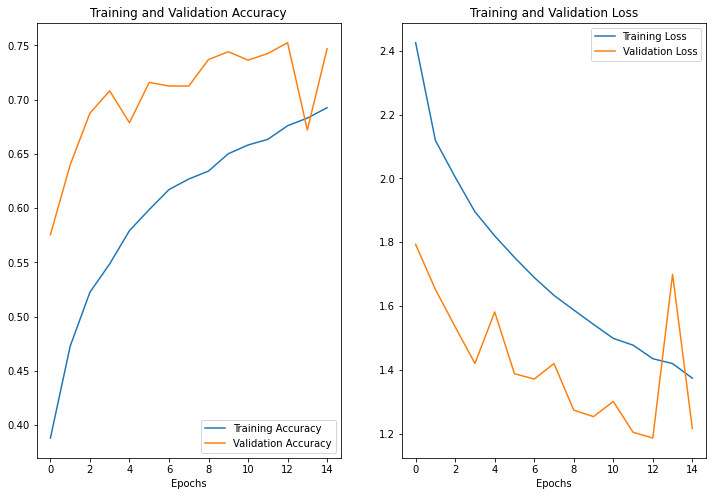

0it [44:48, ?it/s]


KeyboardInterrupt: 

In [72]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

if True:
    # Measure time of KFold
    start_time = time.time()
    epochs = 15
    batch_size = 64
    generator = ImageDataGenerator()
    # Get data for images and labels
    images_df = pd.read_csv("../../Data/HAM10000_metadata.csv")
    images_df = images_df[["image_id","dx"]]
    
    # Remove ids that are in the list of images for validation
    images_df = images_df[~images_df.image_id.isin(validation_image_names)]     
    # Combine image_id with folder path and extention
    # images_df["image_id"] = images_df["dx"] + "/" + images_df["image_id"] + ".jpg"
    images_df["image_id"] = images_df["dx"] + "/" + images_df["image_id"] + ".jpg"
    
    # Perform KFold (Stratified ensures original data distribution)
    # Gather statistics
    kfold = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    statistics_data = [[],[],[],[]]
    
    for train_index, test_index in tqdm(kfold.split(images_df.image_id, images_df.dx)):
        training_data = images_df.iloc[train_index]
        testing_data  = images_df.iloc[test_index]

        training_set = generator.flow_from_dataframe(
                dataframe=training_data, directory=IMAGES_PATH_SEPARATED,
                x_col="image_id", y_col="dx",
                class_mode="categorical", shuffle=True,
                target_size=IMG_SIZE, batch_size=batch_size,
                validate_filenames=False)
        
        testing_set = generator.flow_from_dataframe(
                dataframe=testing_data, directory=IMAGES_PATH_SEPARATED,
                x_col="image_id", y_col="dx",
                class_mode="categorical", shuffle=True,
                target_size=IMG_SIZE, batch_size=batch_size,
                validate_filenames=False)
        
        #print(len(training_set), "training batches")
        #print(len(testing_set) , "testing batches")
        
        model = compile_model()
        fit_model(model, training_set, testing_set, epochs, verbose=True, 
                  augment="kfold_{0}".format(len(statistics_data[0])+1))
        
        # Gather statistics
        train_evaluation = model.evaluate(training_set, verbose=0)
        validation_evaluation = model.evaluate(testing_set, verbose=0)

        statistics_data[0].append(train_evaluation[0]) # loss
        statistics_data[1].append(train_evaluation[1]) # accuracy
        statistics_data[2].append(validation_evaluation[0]) # val_loss
        statistics_data[3].append(validation_evaluation[1]) # val_accuracy

    
    print(" === KFOLD AVERAGE STATISTICS === ")
    print("loss: {0} - accuracy: {1} - val_loss: {2} - val_accuracy: {3}".format(
        np.average(statistics_data[0]), np.average(statistics_data[1]),
        np.average(statistics_data[2]), np.average(statistics_data[3])
    ))
    print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))
    
    '''
    ''';
    # ADAGRAD

## Load Existing Model

In [75]:
# skin_classifier_VGG16_25_ACC_74_VAL_71_good.keras
# skin_classifier_56_kfold_2.keras
# skin_classifier_56_ACC_81_VAL_80_ADAGRAD+MISH_good.keras

if True:
    model = keras.models.load_model(
        "output\keras_models\skin_classifier_VGG16_25_ACC_74_VAL_71_good.keras",
        custom_objects={"mish": mish}
    )
    model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_32 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                      

## Display Convolution Layer Filters

Filters     : 16
Kernel Size : (3, 3)


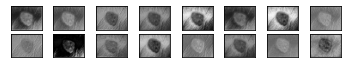

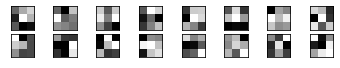

Filters     : 32
Kernel Size : (3, 3)


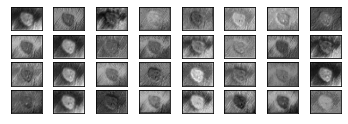

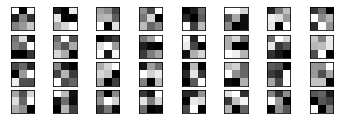

Filters     : 64
Kernel Size : (3, 3)


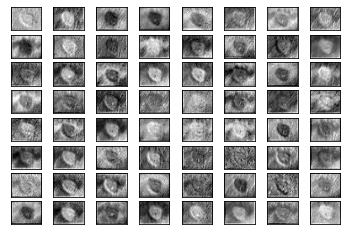

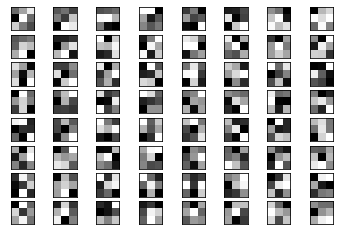

In [295]:
print_filters(model, plot_weights=True)

## Print Confusion Matrix
In this particulac example not a single time 'df' was predicted. Other models strugled with it as well. Idea of combining the models arised, based on multiple weak classifiers forming a stronger classifier in random forest. But ensembling the neural network models didn't work, it is speculated that overwhelming amount of 'nevi' class exapmles is shifting average weights.

Found 1002 files belonging to 7 classes.
Accuracy Score :  0.7545


,precision,sensitivity,specificity,f1-score,total
label,,,,,
akiec,0.5455,0.1818,0.9934,0.2727,33
bcc,0.4833,0.5686,0.9591,0.5225,51
bkl,0.6000,0.3818,0.9623,0.4667,110
df,0.0000,0.0000,1.0000,0.0000,12
mel,0.6875,0.1982,0.9866,0.3077,111
nv,0.7961,0.9657,0.3942,0.8727,671
vasc,0.6000,0.6429,0.9920,0.6207,14


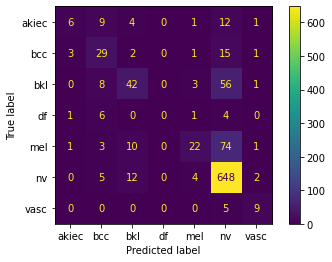

In [417]:
df_stats = print_confusion_matrix(model, IMAGES_PATH_VALIDATION)
df_stats

## Ensemble Multiple Models Weights
This approach is not working due to NV class is overrepresented

In [293]:
model_names = ["skin_classifier_96_kfold_1.keras",
               "skin_classifier_56_kfold_2.keras",
               "skin_classifier_68_kfold_3.keras",
               "skin_classifier_111_kfold_4.keras",
               "skin_classifier_72_kfold_5.keras"]
models = []
weights = [1/len(model_names) for _ in range(1, len(model_names)+1)]
for model_name in model_names:
    current_model = keras.models.load_model(
        ".\output\keras_models\\" + model_name, custom_objects={"mish": mish} )
    models.append(current_model)

# Get average weights from each layer from each model
avg_model_weights = list()
for layer in range( len(models[0].get_weights()) ):
    layer_weights = np.array([model.get_weights()[layer] for model in models])
    avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
    avg_model_weights.append(avg_layer_weights)

# ERROR:  Unknown activation function: mish. 
#         Please ensure this object is passed to the `custom_objects` argument.
# but clone_model does not support custom objects
#model_avg = keras.models.clone_model( models[0] ) #, custom_objects={"mish": mish} )

# Copy model architecture and apply average weights
model_avg = models[0]
model_avg.set_weights(avg_model_weights)
model_avg.compile(optimizer="Adagrad",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

In [459]:
images_df

,image_id,dx
0,bkl/ISIC_0027419.jpg,bkl
2,bkl/ISIC_0026769.jpg,bkl
3,bkl/ISIC_0025661.jpg,bkl
4,bkl/ISIC_0031633.jpg,bkl
5,bkl/ISIC_0027850.jpg,bkl
...,...,...
10010,akiec/ISIC_0033084.jpg,akiec
10011,akiec/ISIC_0033550.jpg,akiec
10012,akiec/ISIC_0033536.jpg,akiec
10013,akiec/ISIC_0032854.jpg,akiec


Found 1002 files belonging to 7 classes.
Accuracy Score :  0.6697


,precision,sensitivity,specificity,f1-score,total
label,,,,,
akiec,0.0000,0.0,1.0,0.0000,33
bcc,0.0000,0.0,1.0,0.0000,51
bkl,0.0000,0.0,1.0,0.0000,110
df,0.0000,0.0,1.0,0.0000,12
mel,0.0000,0.0,1.0,0.0000,111
nv,0.6697,1.0,0.0,0.8022,671
vasc,0.0000,0.0,1.0,0.0000,14


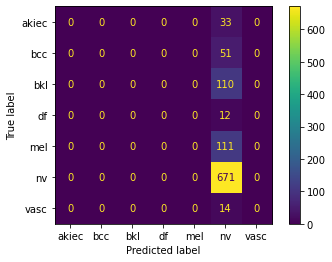

In [320]:
print_confusion_matrix(model_avg, IMAGES_PATH_VALIDATION)

Filters     : 16
Kernel Size : (3, 3)


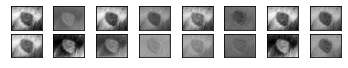

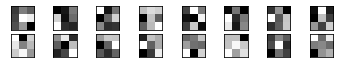

Filters     : 32
Kernel Size : (3, 3)


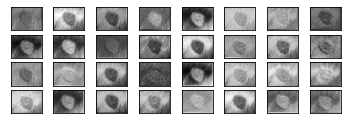

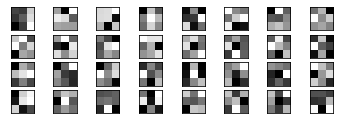

Filters     : 64
Kernel Size : (3, 3)


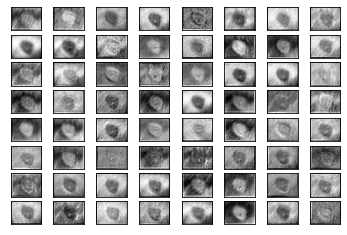

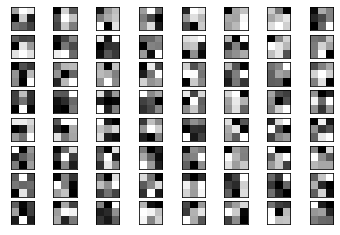

In [296]:
print_filters(model_avg, plot_weights=True)

In [ ]:
'''
Time it initially took to train a network was 462s per epoch
with reduction of image size and changing layers slightly it was down to 60s

Using batch size 32, as 64 overloads RAM on PC and it freezes

462s -> 458s
217s -> 219s    Images halfed
184s -> 186s  
125s -> 123s    Images quortered
166s -> 157s 
77s  -> 60s     Network simplified, 5 KFolds instead of 10 KFolds
44s  -> 40s     Added first layer

Here beta 1 with overfitting example graph
Reducing number of learning parameters, Dropout used
Looked at various loss and cost function, changed from Relu to Mish activation
At this stage Mish activation worked better than Relu, 
noticable difference in smoothness of training and in improvement of VAL_ACC
and reduction of overfitting
[Screenshots Graphs Available]

Noticed overfitting: Looking at regularization L1 and L2
Papers point to 0.005, tried various values, stayed at 0.005
Adding Dropout with 0.3

110s -> 100s 
85s  -> 78s

Changing learning rate, as model is not training over 70% ACC after regularization
Small improvements, removing Dropout layers to counter underfitting
0.0005  : Overfitting after VAL_ACC ~75 to 85 ACC
0.00001 : Way to small, 7 epochs no improvement ACC and VAL_ACC ~66 
0.0001  : Same 

Change Layers to improve accuracy, changed filter kernel size to 7-5-3 (from 3-3-3)

Still overfitting, now ACC ~95+ VAL ~81
Changing Dropout to 0.2 - 0.5 (0.4 chosen)

Swithing back to 3-3-3 kernel sizes.

Network is strugling to learn above 70 (with mish and L2 and Dropout)

Adding Batch Normalization Layer, several at the time, 
combined with few Conv layers then BN or each Conv layer with it's own,
as result removed 2 dropout layers 
as BN works better with several convolutions without dropout beforehand PROVE ME!!!

Tried to changed MaxPolling to AveragePolling, but went back as no advantages noticed

90s -> 89s

360s -> 359s

-> 90s

After changing learning rate it was noticed, 
that different learning rate works better on different epochs,
later epochs work better with larger learning rate, therefore Adagrad was implemented.

"Adagrad is an optimizer with parameter-specific learning rates, 
   which are adapted relative to how frequently a parameter gets updated during training."

Trying Adagrad + Mish 81/77 Not overfitted Good model, saved.  (Adam made it overfit)
Trying Adagrad + Relu ... worse

Proportions in Test/Train data are validated

Solutions Implemented to Improve Model:
1. Train/Test Data Proportion Validation
2. KFold Cross Validation
3. Hyperparameters Tuning (learning_rate, dropout_rate, regularization...)
4. Neural Network Ensemble
5. Batch Normalization
6. L1/L2 Regularization
7. Different Activation Functions (relu, mish, swish)
8. Different Optimizers (adam, adagrad)


NEXT : Transfer Learning  VGG16 vs ResNet50
ResourceExhaustedError: Failed to allocate memory for the batch of component 0 [Op:IteratorGetNext]

EDA: resize rotate crop

VGG16 first try overfitted with 50 and 20 units in Dense layers
    trying bigger values for units 4096,4096
    
Epoch 6/50
544s 5s/step - loss: 0.3679 - accuracy: 0.8554 - val_loss: 1.2280 - val_accuracy: 0.7275

After units set to 4096,4096 even more overfitted at the first epoch

Epoch 1/50
534s 5s/step - loss: 0.3472 - accuracy: 0.8622 - val_loss: 1.2793 - val_accuracy: 0.7247

Tweaking params, adding BatchNormalization
Changed BatchNormalization momentum=0.99 + added Normalization Layer

Changed BatchNormalization momentum=0.9, Normalization Layer, Dense 64-> Dense 32
600s epoch, starting result looks similar.

ResNet50 first run looks the same as VGG16, it looks overfitted...

Normalization techniques applied to transfer learning (BatchNormalization and DropOut)
Using RMSprop optimizer, 10 epoch models seem promising. Needs full testing.

With the original model getting changed with different layers it was decided to check Optimizers again.
This time Adam shown good results, but loss and validation loss aplitude is high (Adam Adagrad ResNet). 
Looks like behaviour depends not only on particular dataset but also on particulat model structure.

///
''';